In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Read the CSV 


In [50]:
df = pd.read_csv("/kaggle/input/eurusd-period-h1/EURUSD.PERIOD_H1.csv")
df.head(10)

,Open,High,Low,Close,Close_open,High_low,Close_low,Close_high,Signal
0,1.08165,1.08223,1.08115,1.08161,-0.00004,0.00108,0.00046,-0.00062,1.0
1,1.08161,1.08311,1.08145,1.08264,0.00103,0.00166,0.00119,-0.00047,1.0
2,1.08263,1.08297,1.08185,1.08295,0.00032,0.00112,0.00110,-0.00002,0.0
3,1.08295,1.08317,1.08147,1.08148,-0.00147,0.00170,0.00001,-0.00169,0.0
4,1.08149,1.08218,1.08104,1.08158,0.00009,0.00114,0.00054,-0.00060,0.0
5,1.08158,1.08170,1.08057,1.08058,-0.00100,0.00113,0.00001,-0.00112,0.0
6,1.08057,1.08106,1.08048,1.08060,0.00003,0.00058,0.00012,-0.00046,0.0
7,1.08059,1.08076,1.08040,1.08040,-0.00019,0.00036,0.00000,-0.00036,0.0
8,1.08039,1.08069,1.08017,1.08057,0.00018,0.00052,0.00040,-0.00012,1.0
9,1.08055,1.08098,1.08049,1.08086,0.00031,0.00049,0.00037,-0.00012,1.0


Split the data into training and validation sets

In [51]:
y = df['Signal'].values
X = df.drop(columns=["Signal"]).values #drop signal from x variables list 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Install XGBoost 

In [52]:
!pip install xgboost

Lets XGBoost and the pipeline for carrying the models

In [53]:
import xgboost as xgb
from sklearn.pipeline import Pipeline

Define the XGBoost parameters

In [54]:
params = {
    'objective': 'binary:logistic',  # For binary classification
    'learning_rate': 0.05,  # Learning rate
    'max_depth': 5,  # Maximum depth of a tree
    'n_estimators': 100,  # Number of trees
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree
    'subsample': 0.9,  # Subsample ratio of the training instances
    'eval_metric': ['auc', 'logloss']  # Evaluation metrics
}

In [55]:
# Create a pipeline with a scaler and the XGBoost classifier
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", xgb.XGBClassifier(**params))
])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eval_metric=['auc', 'logloss'],
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# Testing XGBoost model

Classification Report
               precision    recall  f1-score   support

         0.0       0.71      0.73      0.72       104
         1.0       0.70      0.68      0.69        96

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200



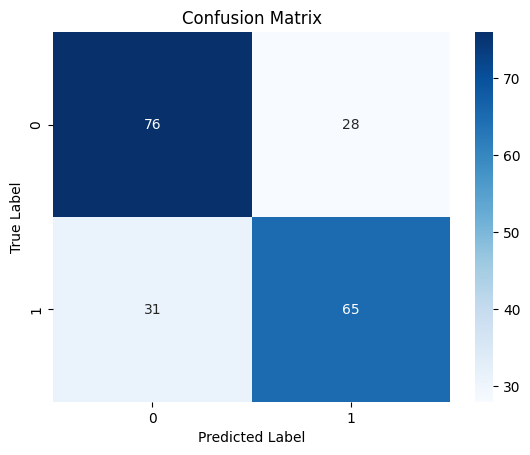

In [56]:
y_pred = pipe.predict(X_test) 

# For binary classification, you might want to threshold the predictions since these are probabilities
y_pred_binary = np.round(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion-matrix xgboost")  # Display the heatmap


print("Classification Report\n",
      classification_report(y_test, y_pred_binary))

## Necessary imports for converting a model to sklearn and saving it ONNX format

Installing the necessary libraries first

In [57]:
!pip install onnxmltools onnxruntime onnx skl2onnx

In [58]:
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster

Registering the Converter

In [59]:
update_registered_converter(
    xgb.XGBClassifier,
    "XGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [False], "zipmap": [True, False, "columns"]},
)

Converting & Saving XGBoost model to onnx

In [60]:
model_onnx = convert_sklearn(
    pipe,
    "pipeline_xgboost",
    [("input", FloatTensorType([None, X_train.shape[1]]))],
    target_opset={"": 12, "ai.onnx.ml": 2},
)

# And save.
with open("xgboost.eurusd.h1.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

# Install Light GBM 
Light GBM doesn't come with sklearn packages it can be installed separately, if not already

In [61]:
!pip install lightgbm

In [62]:
import lightgbm as lgb

## Set parameters for Light GBM Model

In [63]:
params = {
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'objective': 'binary',  # For binary classification (use 'regression' for regression tasks)
    'metric': ['auc','binary_logloss'],  # Evaluation metric
    'num_leaves': 25,  # Number of leaves in one tree
    'n_estimators' : 100, # number of trees
    'max_depth': 5,
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9  # Fraction of features to be used for each boosting round
}

## Train Light GBM model in a Pipeline

In [64]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lgbm", lgb.LGBMClassifier(**params))
])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 398, number of negative: 402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497500 -> initscore=-0.010000
[LightGBM] [Info] Start training from score -0.010000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgbm',
                 LGBMClassifier(feature_fraction=0.9, learning_rate=0.05,
                                max_depth=5, metric=['auc', 'binary_logloss'],
                                num_leaves=25, objective='binary'))])

## Make Predictions and Evaluate

After training the model, use it to make predictions and evaluate its performance.

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Classification Report
               precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       104
         1.0       0.68      0.65      0.66        96

    accuracy                           0.69       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.69      0.68       200



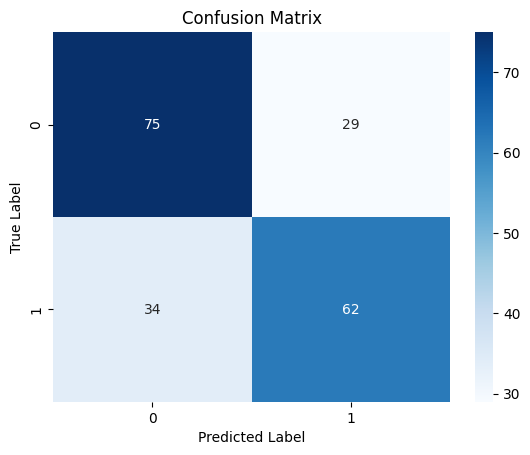

In [65]:
y_pred = pipe.predict(X_test) # Changes from bst to pipe

# For binary classification, you might want to threshold the predictions
y_pred_binary = np.round(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion-matrix lightgbm")  # Display the heatmap


print("Classification Report\n",
      classification_report(y_test, y_pred_binary))

# Save LightGBM to ONNX format

In [66]:
import onnxmltools
from onnxmltools.convert import convert_lightgbm
import onnxmltools.convert.common.data_types
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, update_registered_converter


from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
)  # noqa

from onnxmltools.convert.lightgbm.operator_converters.LightGbm import (
    convert_lightgbm,
)  # noqa

Let's register the converter

In [67]:
update_registered_converter(
    lgb.LGBMClassifier,
    "GBMClassifier",
    calculate_linear_classifier_output_shapes,
    convert_lightgbm,
    options={"nocl": [False], "zipmap": [True, False, "columns"]},
)

Finally let's convert Light GBM model to onnx format

In [68]:
model_onnx = convert_sklearn(
    pipe,
    "pipeline_lightgbm",
    [("input", FloatTensorType([None, X_train.shape[1]]))],
    target_opset={"": 12, "ai.onnx.ml": 2},
)

# And save.
with open("lightgbm.eurusd.h1.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

# Other Models

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Initiate the models we are going to use

In [70]:
classifiers = {
    "Logistic Regression": LogisticRegression(solver="lbfgs"),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC()
}

Lets Normalize the input data first

In [71]:
scaler = StandardScaler()

x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

Run the same data across different models

Logistic Regression
Classification Report
               precision    recall  f1-score   support

         0.0       0.69      0.76      0.72       104
         1.0       0.71      0.62      0.66        96

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.69      0.69       200



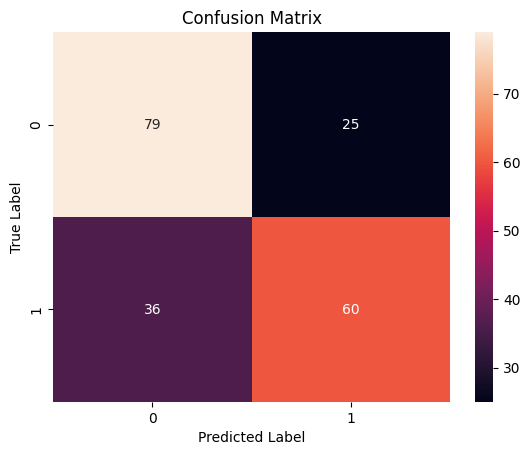

Decision Tree
Classification Report
               precision    recall  f1-score   support

         0.0       0.63      0.56      0.59       104
         1.0       0.57      0.65      0.61        96

    accuracy                           0.60       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.60      0.60      0.60       200



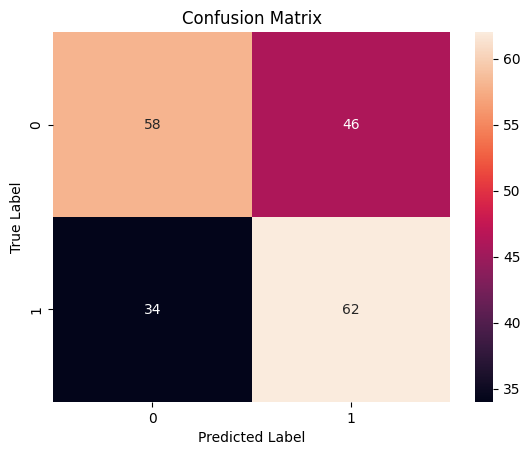

Naive Bayes
Classification Report
               precision    recall  f1-score   support

         0.0       0.67      0.87      0.75       104
         1.0       0.78      0.53      0.63        96

    accuracy                           0.70       200
   macro avg       0.73      0.70      0.69       200
weighted avg       0.72      0.70      0.70       200



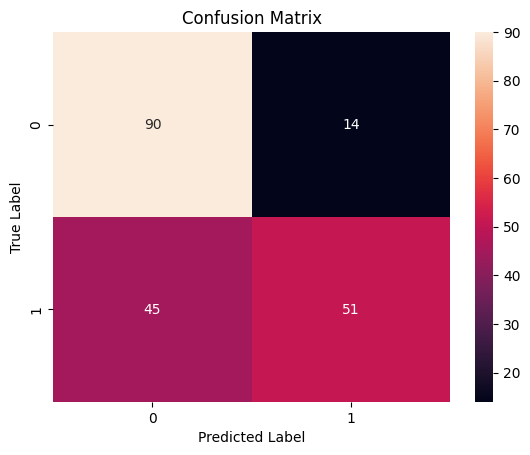

K-Nearest Neighbors
Classification Report
               precision    recall  f1-score   support

         0.0       0.68      0.73      0.71       104
         1.0       0.69      0.64      0.66        96

    accuracy                           0.69       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.69      0.69      0.68       200



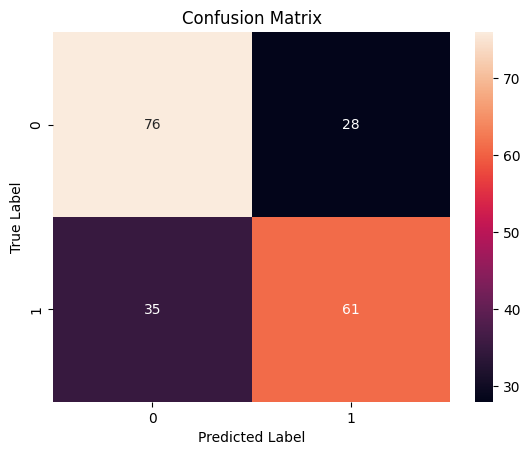

Support Vector Machine
Classification Report
               precision    recall  f1-score   support

         0.0       0.69      0.69      0.69       104
         1.0       0.66      0.66      0.66        96

    accuracy                           0.68       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.68      0.67       200



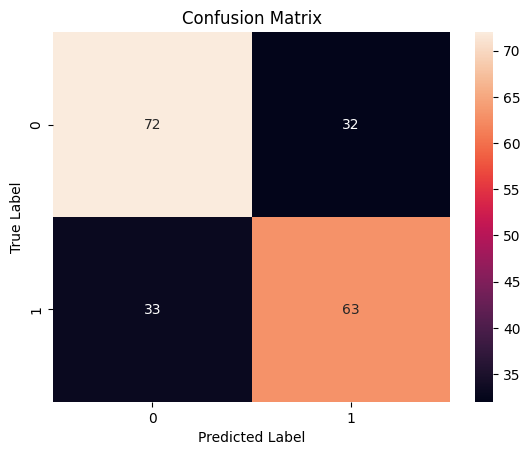

In [72]:
# Evaluate performance using a dictionary

for classifier_name, classifier in classifiers.items():
    
    # Train the classifier
    classifier.fit(x_train, y_train)

    # Make predictions on the test set
    
    y_pred = classifier.predict(x_test)
    
    print(f"{classifier_name}\nClassification Report\n",classification_report(y_test, y_pred))
    
    # Create a heatmap using Seaborn for each classifier's confusion matrix
    plt.figure()  # Create a new figure for each confusion matrix
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")  # 'd' formats entries as integers
    ax.set_title(f"Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()  # Display the heatmap